In [1]:
from torch import nn, Tensor
import math
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pandas import to_datetime
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import gc
import tqdm
import matplotlib.pyplot as plt

In [2]:
de = pd.read_csv('DETotal.csv')

In [3]:
de.head(5)

,Hourly Time,Hourly Sum
0,01.01.2015 00:00,173819
1,01.01.2015 01:00,167853
2,01.01.2015 02:00,162471
3,01.01.2015 03:00,159747
4,01.01.2015 04:00,157090


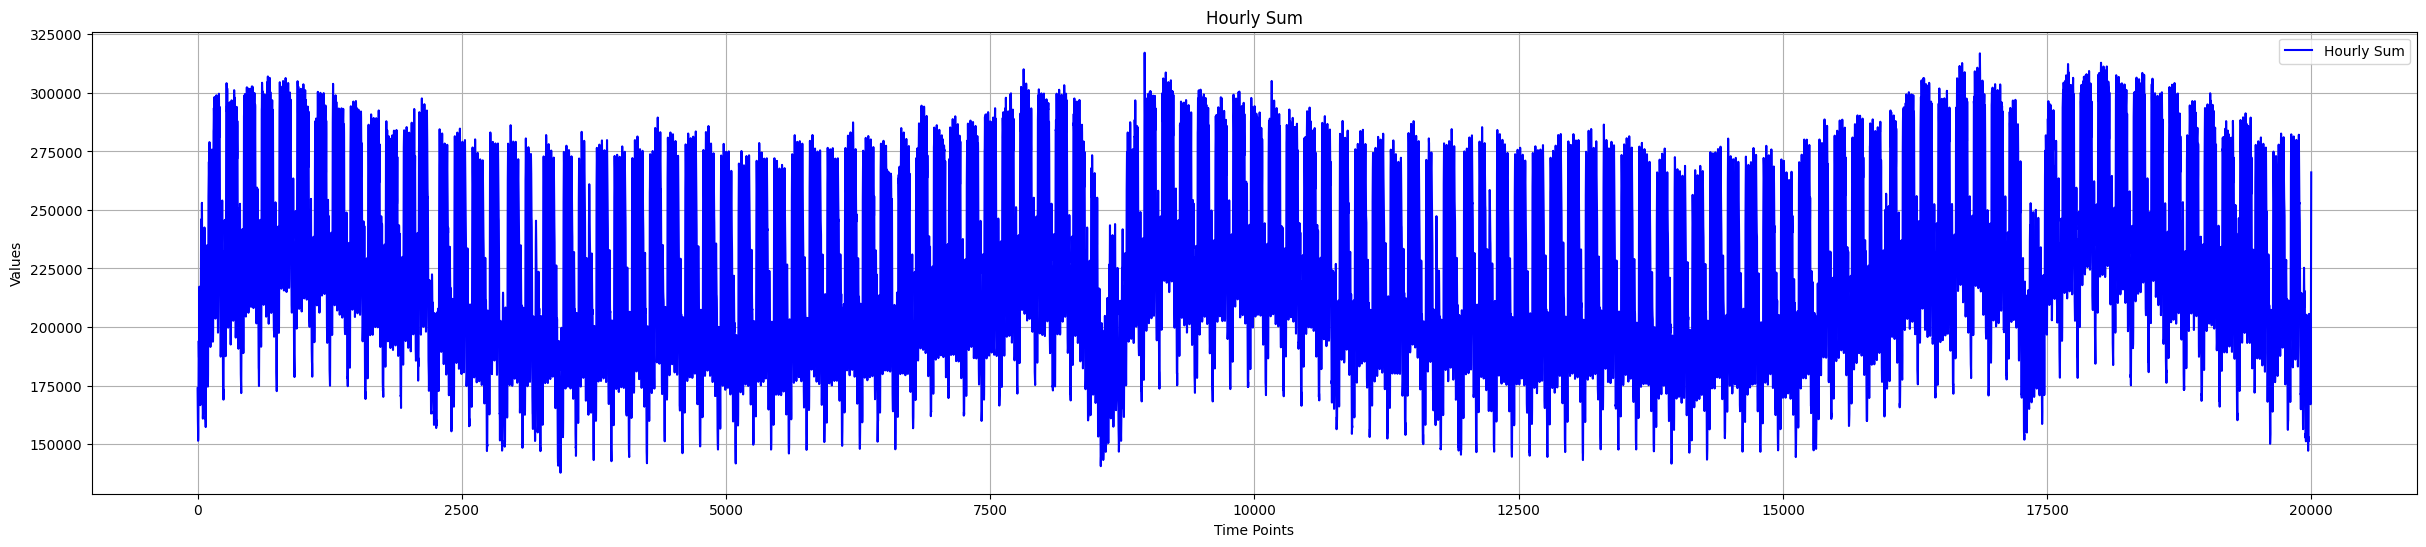

In [4]:
plt.figure(figsize=(30, 6))
plt.plot(de['Hourly Sum'], label='Hourly Sum', color='blue')

plt.title('Hourly Sum')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.legend()

plt.grid(True)
plt.show()

In [6]:
print('number of data(de) : ',len(de))

number of data(de) :  76705
number of data(kepco) :  69408


In [7]:
#'Hourly Time'을 datetime 객체로 변환
de['Hourly Time'] = to_datetime(de['Hourly Time'], format='%d.%m.%Y %H:%M')

#추가적인 시간 관련 특징을 추출
de['weekday'] = de['Hourly Time'].dt.dayofweek  
de['hour'] = de['Hourly Time'].dt.hour         
de['month'] = de['Hourly Time'].dt.month
de.head(5)

,Hourly Time,Hourly Sum,weekday,hour,month
0,2015-01-01 00:00:00,173819,3,0,1
1,2015-01-01 01:00:00,167853,3,1,1
2,2015-01-01 02:00:00,162471,3,2,1
3,2015-01-01 03:00:00,159747,3,3,1
4,2015-01-01 04:00:00,157090,3,4,1


In [8]:
#24시간 단위로 scaling하는 함수
def scale_in_chunks(data, chunk_size):
    scaled_data = []
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size]
        chunk_reshaped = chunk.reshape(-1, 1)
        if i == 0 or len(chunk) == chunk_size:
            scaled_chunk = scaler.fit_transform(chunk_reshaped)
        else:
            scaled_chunk = scaler.transform(chunk_reshaped)
        scaled_data.extend(scaled_chunk.flatten())
    return np.array(scaled_data)

In [9]:
#'Hourly Sum' 전력 사용량 데이터 정규화
scaler = StandardScaler()
hourly_sum = np.array(de['Hourly Sum'])
month = np.array(de['month'])
hour = np.array(de['hour'])

scaled_hourly_sum = scale_in_chunks(hourly_sum, 24)
scaled_month = scale_in_chunks(month, 24)
scaled_hour = scale_in_chunks(hour, 24)


de['Hourly Sum'] = scaled_hourly_sum
de['month'] = scaled_month
de['hour'] = scaled_hour

# 데이터 프레임에서 필요한 열만 선택
processed_de = de[['Hourly Sum', 'month','hour']]
processed_de.head()

,Hourly Sum,month,hour
0,-0.444291,0.0,-1.661325
1,-0.739907,0.0,-1.516862
2,-1.006586,0.0,-1.372399
3,-1.141561,0.0,-1.227936
4,-1.273215,0.0,-1.083473


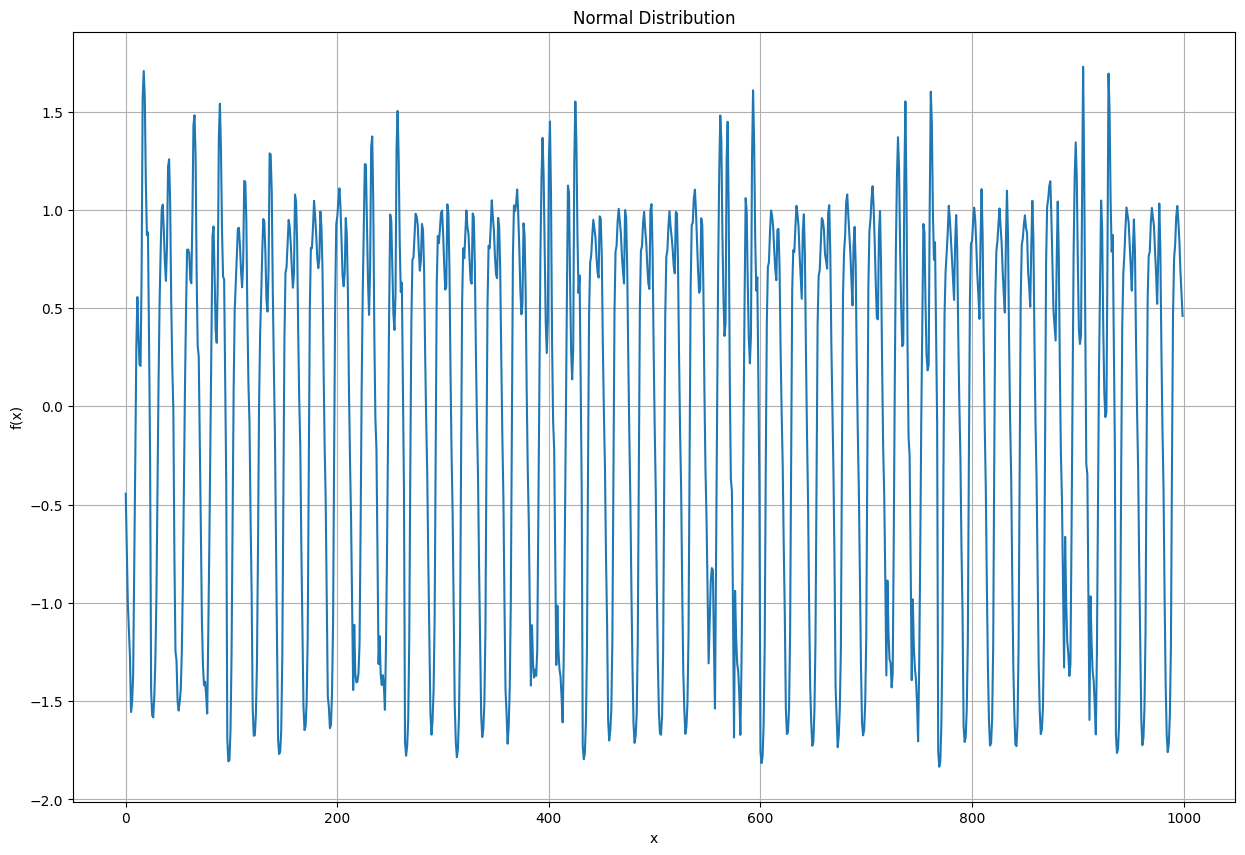

In [10]:
#정규화 결과 확인
plt.figure(figsize=(15,10))
plt.title('Normal Distribution')
plt.xlabel('x') 
plt.ylabel('f(x)')
plt.grid() 
plt.plot(processed_de['Hourly Sum'][0:1000])
plt.show()

In [11]:
train_de = processed_de[:int(0.85*len(processed_de))]
test_de = processed_de[int(0.85*len(processed_de)):]
train_de.shape, test_de.shape

((65199, 3), (11506, 3))

In [12]:
# 설정된 시퀀스 길이와 예측 길이
sequence_length = 168  
prediction_length = 24 

# 시퀀스 데이터를 생성하는 함수
def create_sequences(de, sequence_length, prediction_length):
    X = []
    y = []

    for i in range(len(de) - sequence_length - prediction_length + 1):
        X.append(de[i:(i + sequence_length)].values)
        y.append(de[(i + sequence_length):(i + sequence_length + prediction_length)]['Hourly Sum'].values)

    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = create_sequences(train_de, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_de, sequence_length, prediction_length)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(65008, 168, 3) (65008, 24)
(11315, 168, 3) (11315, 24)


In [13]:
from sklearn.model_selection import train_test_split

# 데이터를 학습 세트와 검증 세트로 분할 (시간 순서를 유지하기 위해 shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# 결과 확인
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((52006, 168, 3), (13002, 168, 3), (52006, 24), (13002, 24))

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, model_dim))
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=model_dim * 4, dropout=dropout,batch_first = True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(model_dim, output_dim)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.input_linear(x) + self.positional_encoding
        mask = self.generate_square_subsequent_mask(x.size(1)).to(x.device)
        x = self.transformer_encoder(x, mask)
        return self.output_linear(x[:, -1, :])

# 모델 인스턴스 생성
input_dim = X_train.shape[-1]  # 입력 차원
model_dim = 256  # 모델의 특징 차원
num_heads = 8  # 어텐션 헤드의 수
num_layers = 4  # 인코더 레이어의 수
output_dim = y_train.shape[-1]  # 출력 차원

model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim)

# 손실 함수와 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 요약
model, criterion, optimizer

(TransformerModel(
   (input_linear): Linear(in_features=3, out_features=256, bias=True)
   (encoder_layer): TransformerEncoderLayer(
     (self_attn): MultiheadAttention(
       (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
     )
     (linear1): Linear(in_features=256, out_features=1024, bias=True)
     (dropout): Dropout(p=0.1, inplace=False)
     (linear2): Linear(in_features=1024, out_features=256, bias=True)
     (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
     (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
     (dropout1): Dropout(p=0.1, inplace=False)
     (dropout2): Dropout(p=0.1, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
         )
         (linear1): Linear(in_fea

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TransformerModel(
  (input_linear): Linear(in_features=3, out_features=256, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=1024, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1024, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_featur

In [16]:
# PyTorch에서 사용할 데이터를 tensor로 변환
X_train_tensor = torch.Tensor(X_train).to(device)
y_train_tensor = torch.Tensor(y_train).to(device)
X_val_tensor = torch.Tensor(X_val).to(device)
y_val_tensor = torch.Tensor(y_val).to(device)

# TensorDataset과 DataLoader를 사용하여 데이터 로드
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [17]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    for epoch in range((num_epochs)):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target).item()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

In [18]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Epoch 1/30, Train Loss: 0.1489, Val Loss: 0.1068
Epoch 2/30, Train Loss: 0.1249, Val Loss: 0.1120
Epoch 3/30, Train Loss: 0.1237, Val Loss: 0.1013
Epoch 4/30, Train Loss: 0.1271, Val Loss: 0.1072
Epoch 5/30, Train Loss: 0.1256, Val Loss: 0.0886
Epoch 6/30, Train Loss: 0.1223, Val Loss: 0.0964
Epoch 7/30, Train Loss: 0.1217, Val Loss: 0.1107
Epoch 8/30, Train Loss: 0.1170, Val Loss: 0.0952
Epoch 9/30, Train Loss: 0.1281, Val Loss: 0.0638
Epoch 10/30, Train Loss: 0.1246, Val Loss: 0.0799
Epoch 11/30, Train Loss: 0.1365, Val Loss: 0.0486
Epoch 12/30, Train Loss: 0.1648, Val Loss: 0.0554
Epoch 13/30, Train Loss: 0.1242, Val Loss: 0.0649
Epoch 14/30, Train Loss: 0.1436, Val Loss: 0.0582
Epoch 15/30, Train Loss: 0.1507, Val Loss: 0.0548
Epoch 16/30, Train Loss: 0.1392, Val Loss: 0.0554
Epoch 17/30, Train Loss: 0.1198, Val Loss: 0.0560
Epoch 18/30, Train Loss: 0.1342, Val Loss: 0.0666
Epoch 19/30, Train Loss: 0.1270, Val Loss: 0.0492
Epoch 20/30, Train Loss: 0.1310, Val Loss: 0.0536
Epoch 21/

In [167]:
weights_path = './weights/'
torch.save(model.state_dict(), 'model_weights_de.pth')

In [20]:
def split_data(X_test,split_len):
    data_list = []
    test_len = int(len(X_test)/split_len)
    for i in range(test_len):
        data_list.append(X_test[i:i+split_len])
        i+=split_len
    return data_list, test_len

def to_tensor(X_test):
    X_test_tensor = torch.tensor(X_test,dtype=torch.float32).to(device)
    return X_test_tensor

y_test_tensor = torch.tensor(y_test,dtype=torch.float32)

data_list,test_len = split_data(X_test,155)

for i in range(test_len):
    data_list[i] = to_tensor(data_list[i])

In [21]:
predictions_tensor = []

model.eval()
with torch.no_grad():
    for i in range(test_len):
        temp = model(data_list[i])
        predictions_tensor.append(temp)
        gc.collect()
        torch.cuda.empty_cache()

In [22]:
predictions_tensor = [tensor.cpu() for tensor in predictions_tensor]
predictions = np.array(predictions_tensor)
predictions = predictions.reshape(-1,predictions.shape[2])
y_test = np.array(y_test_tensor)

In [42]:
y_test.shape

(11315, 24)

In [23]:
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test,predictions)**0.5

def mean_absolute_percentage_error(y_test, predictions): 
    y_test, predictions = np.array(y_test), np.array(predictions)
    non_zero_mask = y_test != 0  
    return np.mean(np.abs((y_test[non_zero_mask] - predictions[non_zero_mask]) / y_test[non_zero_mask])) * 100
mape = mean_absolute_percentage_error(y_test, predictions)

r_squared = r2_score(y_test, predictions).round(5)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r_squared}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1.1184049844741821
Mean Absolute Percentage Error (MAPE): 297.9109287261963%
R-squared (R²): -1.02479


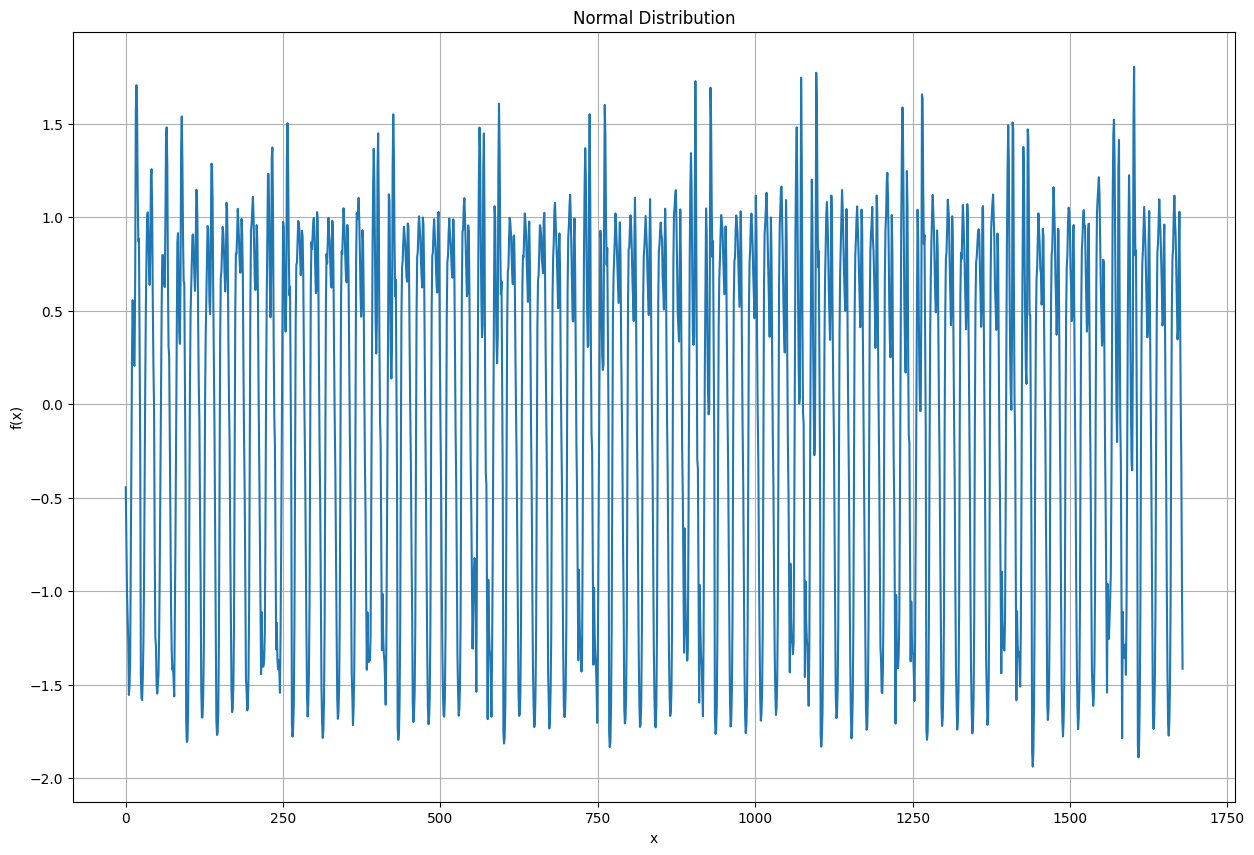

In [24]:
from scipy.stats import norm
plt.figure(figsize=(15,10)) #5
plt.title('Normal Distribution') #6
plt.xlabel('x') #7
plt.ylabel('f(x)') #8
plt.grid() #9
plt.plot(processed_de['Hourly Sum'][0:1680]) #10
plt.show() #11

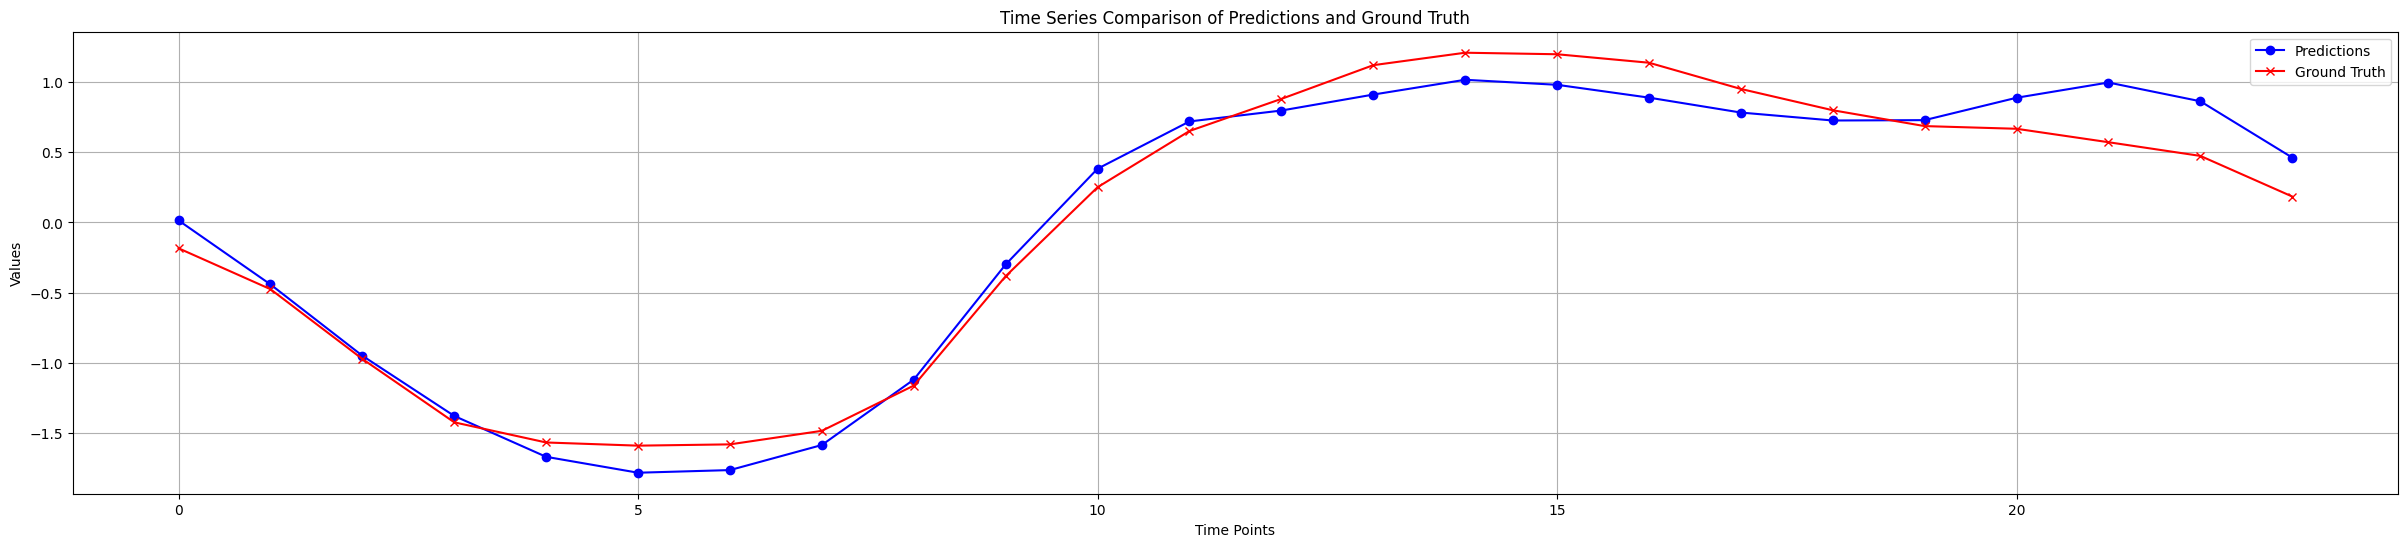

In [152]:
plt.figure(figsize=(30, 6))
plt.plot(predictions[150], label='Predictions', color='blue', marker='o')
plt.plot(y_test[150], label='Ground Truth', color='red', marker='x')  

plt.title('Time Series Comparison of Predictions and Ground Truth')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.legend()

plt.grid(True)
plt.show()

In [90]:
pred = predictions.reshape(-1,1)
y_test_1d = y_test.reshape(-1,1)
print(len(pred))

271560


In [127]:
y_train_1d = y_train.reshape(-1,1)

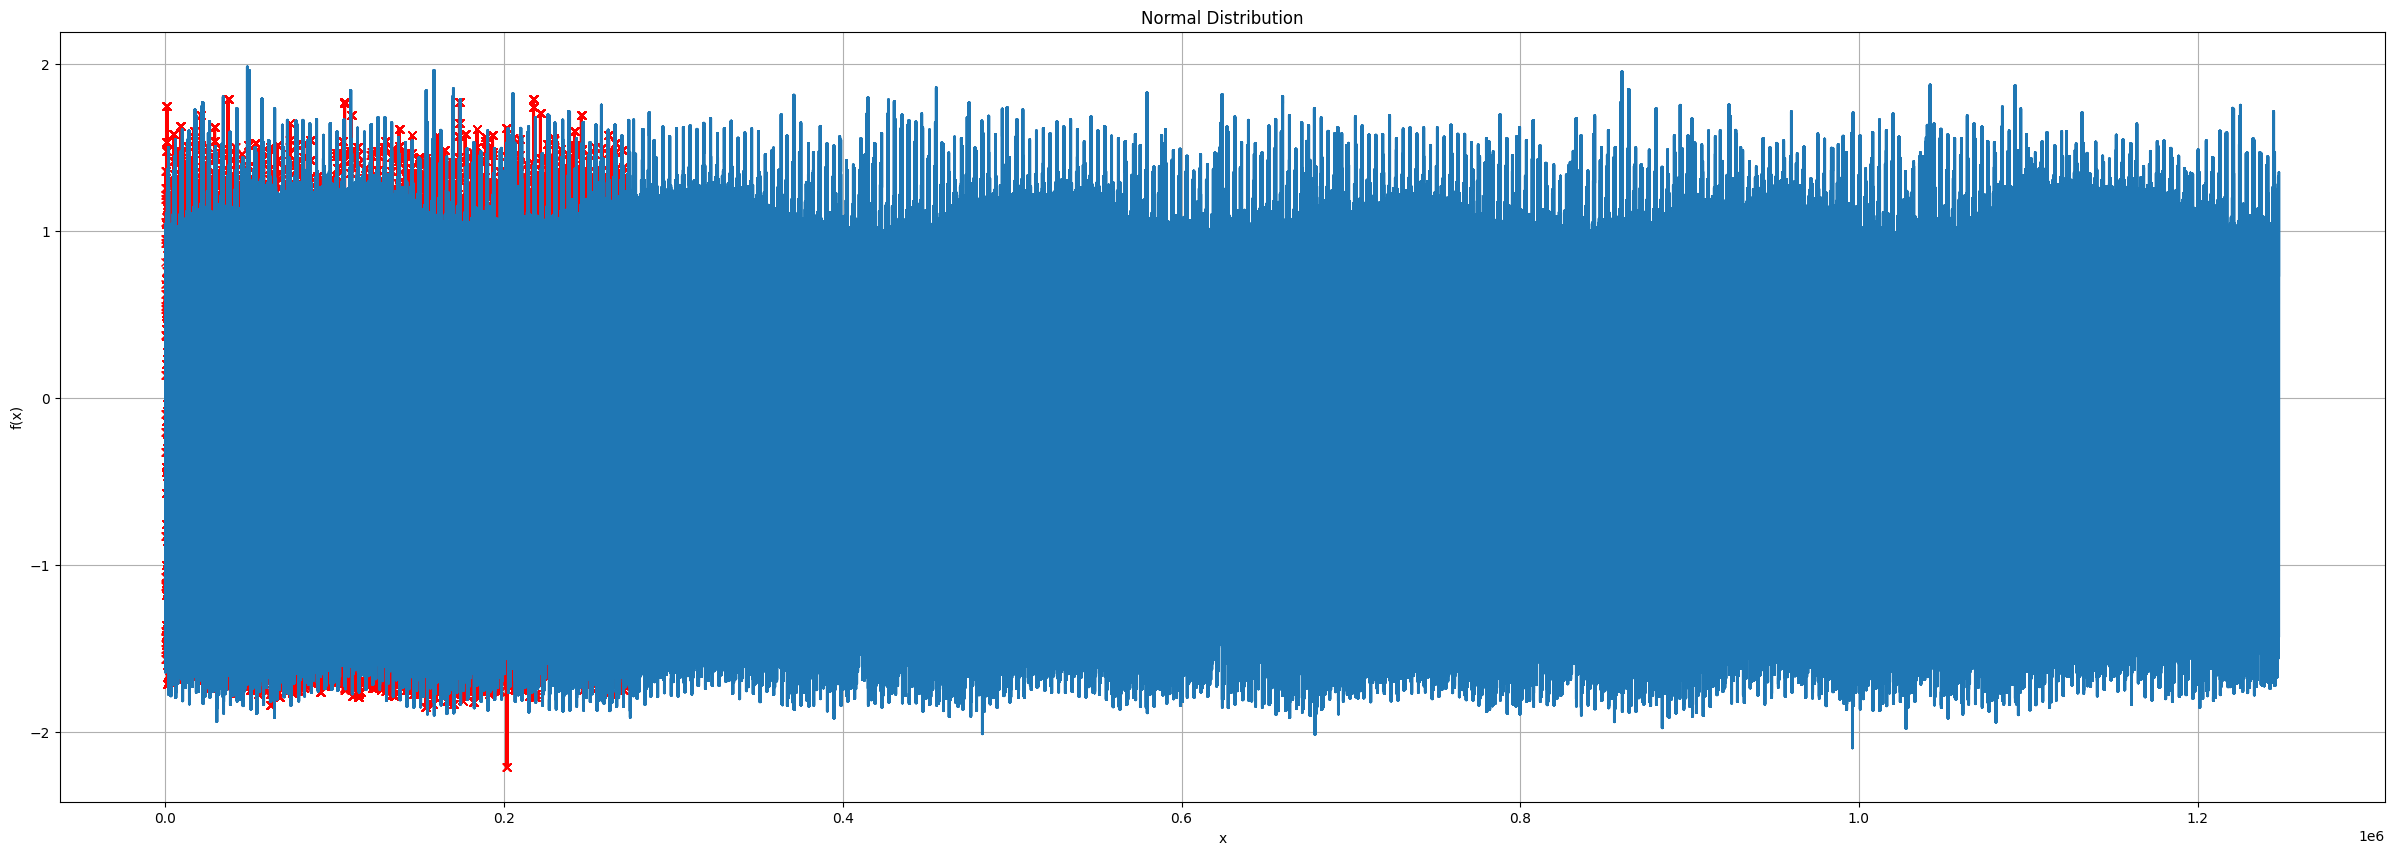

In [166]:
plt.figure(figsize=(30,10))
plt.title('Ground Truth and Predictions') 
plt.xlabel('Time stamp')
plt.ylabel('Hourly Sum') 
plt.grid()
plt.plot(y_test_1d, label='Ground Truth', color='red', marker='x')
plt.plot(y_train_1d,label='Predictions', color='blue', marker='o') 
plt.show()